In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import math
import pandas as pd
#import uproot
import uproot3
from scipy import optimize as op
import scipy.integrate as integrate

In [3]:
#Gain access to functions used to change some of the aspects regarding arrays and the things in them
%run /Users/cmc/analysis_phd/analysis_twopi_clas6/cut_determinations/e16/Bin\ Conversions.ipynb

#Gain Access to functions used to work with momentum binning
%run /Users/cmc/analysis_phd/analysis_twopi_clas6/cut_determinations/e16/Momentum\ Bins.ipynb

#Gain Access to functions used to work with Fitting Functions
%run /Users/cmc/analysis_phd/analysis_twopi_clas6/cut_determinations/e16/Fitting\ Functions.ipynb

#Gain Access to functions used for TH2s 
#uproot or uproo4
#%run /Users/cmc/analysis_phd/analysis_twopi_clas6/cut_determinations/e16/TH2\ Functions-uproot3.ipynb
#uproot3
%run /Users/cmc/analysis_phd/analysis_twopi_clas6/cut_determinations/e16/TH1\ Functions-uproot3.ipynb

#Gain Access to functions for taking discrete derivatives of lists of data
%run /Users/cmc/analysis_phd/analysis_twopi_clas6/cut_determinations/e16/Derivatives.ipynb

*Bin Conversions*
Available Functions:
Note: All functions return new arrays rather than altering the previous array
	New_Merged_Size(array_,merge_size_) returns what the size of the new merged array will be
	Merge_Bin_Edges(edges_,merge_size) merges the bin edges 
	Merge_Bins(array_,merge_size_) adds together every <merge_size_> values in an array
	Merge_Vals(yarray_,merge_size_) adds together every <merge_size_> ybin together in an array
	Merge_Bins(xarray_,merge_size_) averages every <merge_size_> xbins together in an array
	Count_Non_Zero(array_) counts the number of nonzero values in an array
	Count_Zero(array_) counts the number of zeros in an array
	Remove_Zeros(array_) remove zeros from an array
	Remove_Zeros_Y(yarray_) removes zero values from yarray
	Remove_Zeros_X(xarray_,yarray_) removes xbins where the corresponding y value was zero
	Count_InBounds(yarray_,low_,high_) counts the number of values that fall between bounds (or equal to)
	Count_OutBounds(yarray_,low_,high_) co

In [12]:
run="e1f"
sim="exp"

filled_date = "05-31-2024"
empty_date = "06-18-2024"
sim_date = "05-28-2024"
#filled_dir = "/Users/cmc/analysis_phd/root_files/cut_determination/cut_det_e1f/"+filled_date
filled_dir = "/Users/cmc/analysis_phd/root_files/cut_determination/cut_det_"+run+"/"+filled_date
empty_dir = "/Users/cmc/analysis_phd/root_files/cut_determination/cut_det_"+run+"/"+empty_date
#sim_dir = "/Users/cmc/analysis_phd/root_files/cut_determination/cut_det_"+run+"/"+sim_date

filled_rootfile = filled_dir+"/exp_"+run+"_clas6_vertex_"+filled_date+".root"
empty_rootfile = empty_dir+"/exp_empty_"+run+"_clas6_vertex_"+empty_date+".root"
#empty_rootfile = empty_dir+"/"+sim+"_empty_"+run+"_clas6_vertex_"+empty_date+".root"
#sim_rootfile = empty_dir+"/sim_"+run+"_clas6_vertex_"+sim_date+".root"

filled_file = uproot3.open(filled_rootfile)
empty_file = uproot3.open(empty_rootfile)
#sim_file= uproot3.open(sim_rootfile)



edge_fracs = [0.0,0.8,1.6]
gaus_fracs = [0.1,0.01,0.0001]

sector_names = ["sec1","sec2","sec3","sec4","sec5","sec6","all"]

color_order = ['b','g','r']
rv_color_order = ['r','g','b']
cut_name = ['tight','mid','loose']
rv_cut_name = ['loose','mid','tight']

Qr = 13.67


In [13]:
layer1 = "Vertex"
layer2 = "vertex_pid"
layer3 = layer2+"_cut"
layer4 = [layer3+"_mnone_"+sector_names[sec] for sec in range(6)]

hist_e = [empty_file[layer1+"/"+layer2+"/"+layer3+"/"+layer4[sec]+"/"+layer4[sec]] for sec in range(6)]
hist_f = [filled_file[layer1+"/"+layer2+"/"+layer3+"/"+layer4[sec]+"/"+layer4[sec]] for sec in range(6)]
#hist_s = [sim_file[layer1+"/"+layer2+"/"+layer3+"/"+layer4[sec]+"/"+layer4[sec]] for sec in range(6)]




In [14]:
xbins = Num_Xbins(hist_e[0])
xedges = XEdges_1d(hist_e[0])
xvals = Center_Xbins(hist_e[0])
yvals_e = [Values_1d(hist_e[sec]) for sec in range(6)]
yvals_eq = [[yvals_e[sec][i] * Qr for i in range(len(yvals_e[sec]))] for sec in range(6)]
yvals_f = [Values_1d(hist_f[sec]) for sec in range(6)]
#yvals_s = [Values_1d(hist_s[sec]) for sec in range(6)]
yerr_e = [Errors_1d(hist_e[sec]) for sec in range(6)]
yerr_eq = [[yerr_e[sec][i] * Qr for i in range(len(yerr_e[sec]))] for sec in range(6)]
yerr_f = [Errors_1d(hist_f[sec]) for sec in range(6)]
#yerr_s = [Errors_1d(hist_s[sec]) for sec in range(6)]



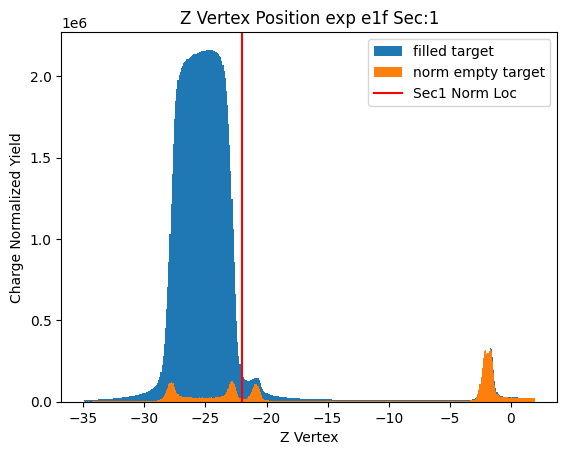

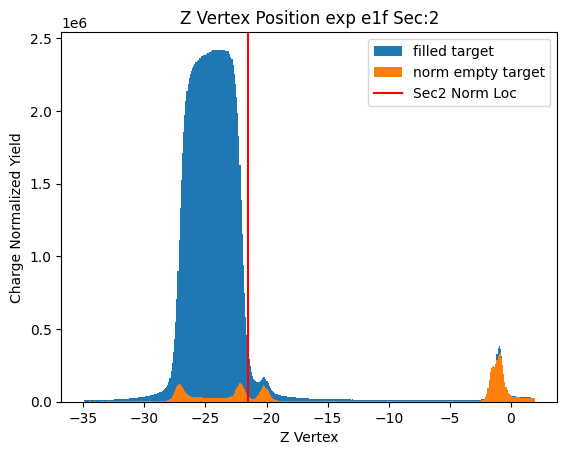

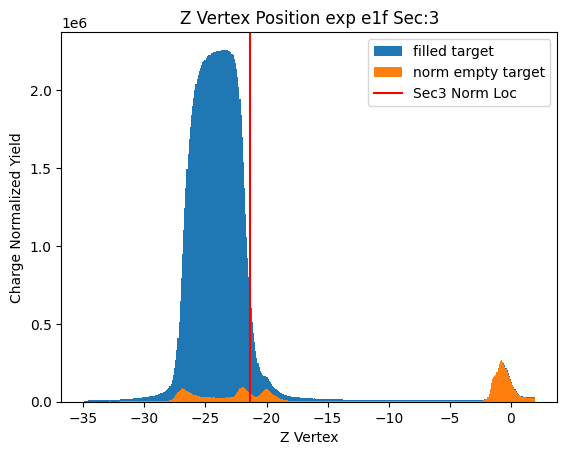

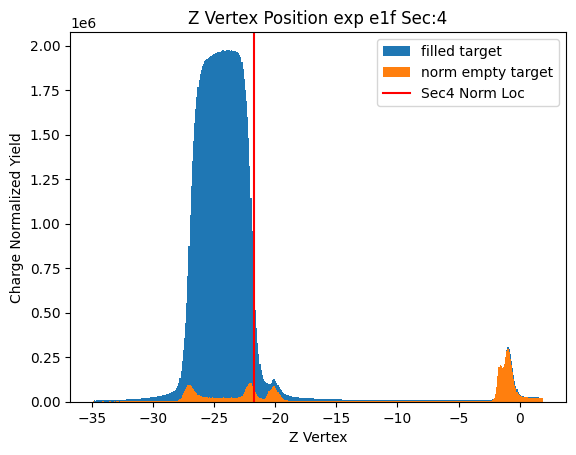

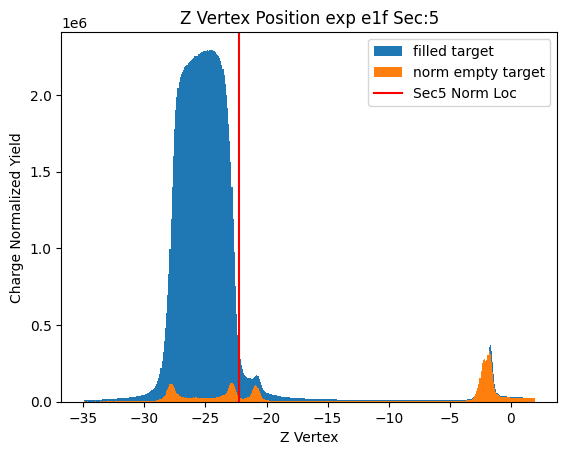

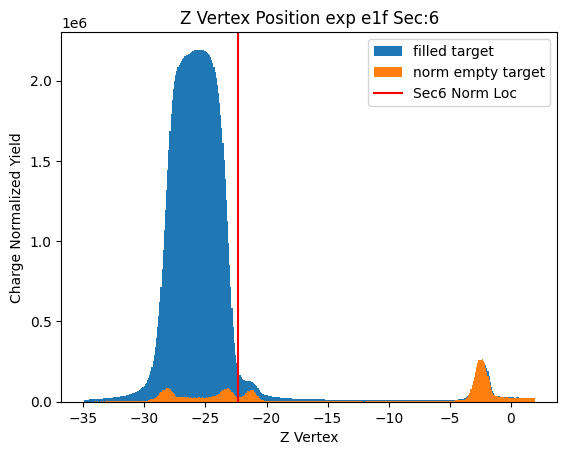

In [15]:
#Identify Initial Peak to normalize to

norm_idx = [140,145,147,143,137,136]

for sec in range(6):
    plt.hist(xvals,weights=yvals_f[sec],label="filled target",bins=len(xvals))
    plt.hist(xvals,weights=yvals_eq[sec],label="norm empty target",bins=len(xvals))
    #plt.scatter(xvals,yvals_eq[sec],label="norm empty target")
    #plt.scatter(xvals,yvals_f,label="filled target")
    plt.axvline(x=xvals[norm_idx[sec]],label="Sec{} Norm Loc".format(sec+1),color='r')
    plt.title("Z Vertex Position {} {} Sec:{}".format(sim,run,sec+1))
    plt.xlabel("Z Vertex")
    plt.ylabel("Charge Normalized Yield")
    plt.legend()
    plt.show()


In [16]:
yvals_sub = [[yvals_f[sec][i]-yvals_eq[sec][i] for i in range(len(yvals_e[sec]))] for sec in range(6)]


In [17]:
def super_gaus_cut_bound(frac_,side_,a_,m_,s_,p_):
    if side_ == 0:
        return 0.5*(2*m_ - 2 * (math.log(1./frac_)**(1./p_))*(2**(p_/2.)*(1./s_)**(-p_))**(1./p_))
    elif side_ ==1:
        return 0.5*(2*m_ + 2 * (math.log(1./frac_)**(1./p_))*(2**(p_/2.)*(1./s_)**(-p_))**(1./p_))
    else:
        return -99.9
    

def Sup_Gaus_Cutoff(x_,frac_,a_,m_,s_,p_):
    if x < super_gaus_cut_bound(frac_,0,a_,m_,s_,p_):
        return 0.
    elif x > super_gaus_cut_bound(frac_,1,a_,m_,s_,p_):
        return 0.
    else:
        return Super_Gaus(x_,a_,m_,s_,p_)
    
def Sup_Gaus_Cutoff_Array(x_,frac_,a_,m_,s_,p_):
    output = np.zeros(len(x_))
    for i in range(len(x_)):
        output[i] = Sup_Gaus_Cutoff(x_[i],frac_,a_,m_,s_,p_)
    return output

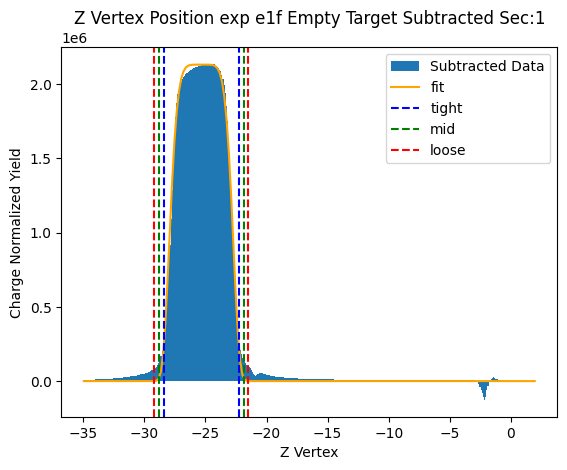

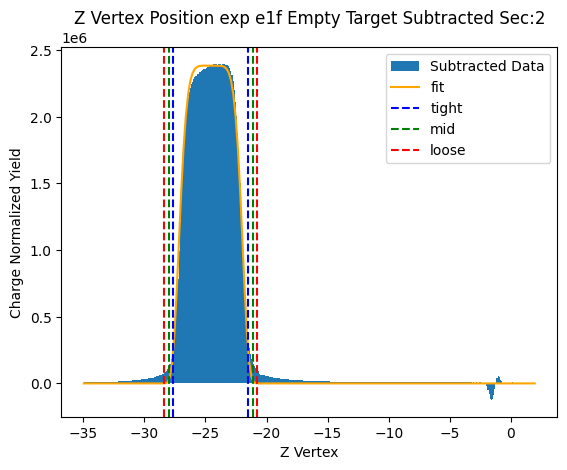

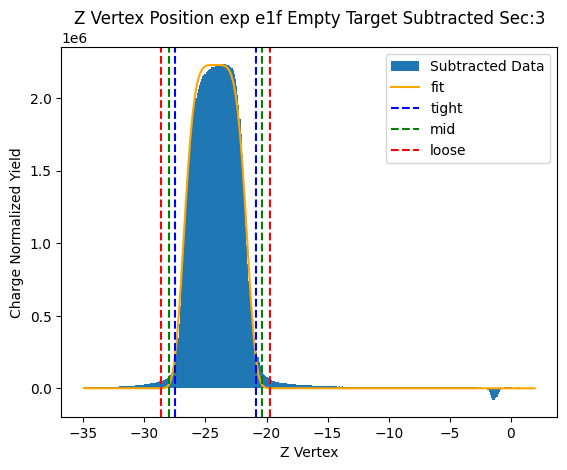

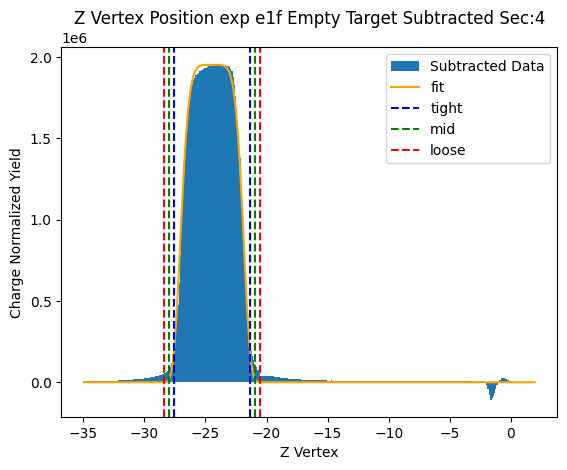

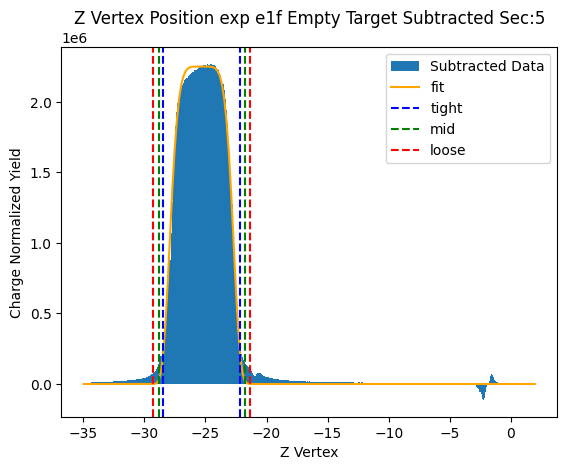

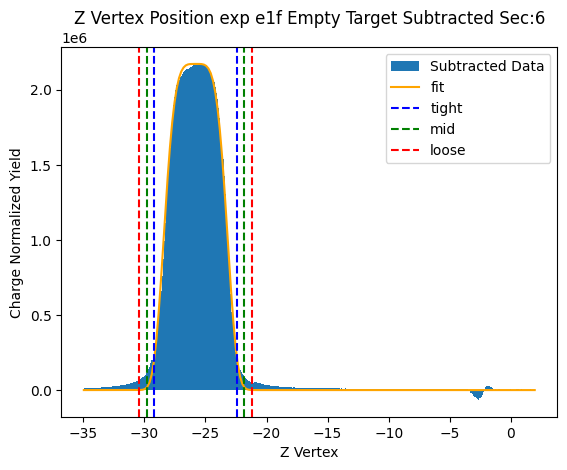

In [18]:
ini_pars = [600000,-25.0,5.0,10.0]

cut_edges = np.zeros((6,2,3))

fit_pars = np.zeros((6,4))

for sec in range(6):
    plt.hist(xvals,weights=yvals_sub[sec],label="Subtracted Data",bins=len(xvals))
    #plt.scatter(xvals,yvals_sub[sec],label="Subtracted Data")
    #plt.scatter(xvals,yvals_f,label="filled target")
    try:
        pars, pars_cov = op.curve_fit(Super_Gaus,xvals,yvals_sub[sec],p0=ini_pars,maxfev=5000)
        cont_x = np.linspace(xvals[0],xvals[xbins-1],200)
        plt.plot(cont_x,Super_Gaus(cont_x,*pars),label="fit",color='orange')
        for i in range(4):
            fit_pars[sec][i] = pars[i]
        for j in range(2):
            for k in range(3):
                cut_edges[sec][j][k] = super_gaus_cut_bound(gaus_fracs[k],j,*pars)
                if j == 0:
                    plt.axvline(x=cut_edges[sec][j][k],color=color_order[k],linestyle="dashed",label=cut_name[k])
                else:
                    plt.axvline(x=cut_edges[sec][j][k],color=color_order[k],linestyle="dashed")
    except RuntimeError:
        print("Runtime Error")
    except ValueError:
        print("Value Error") 
    plt.title("Z Vertex Position {} {} Empty Target Subtracted Sec:{}".format(sim,run,sec+1))
    plt.xlabel("Z Vertex")
    plt.ylabel("Charge Normalized Yield")
    plt.legend()
    plt.show()
    
    
    

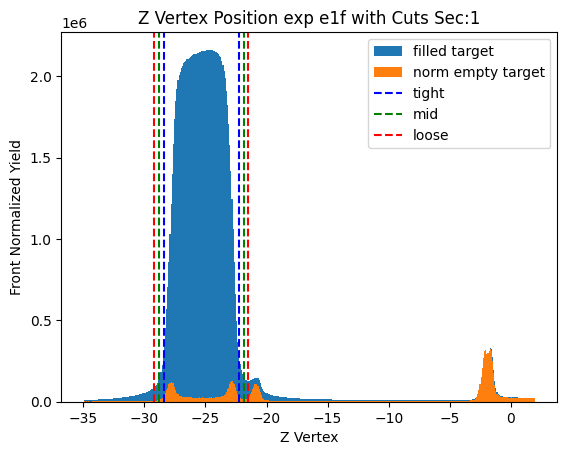

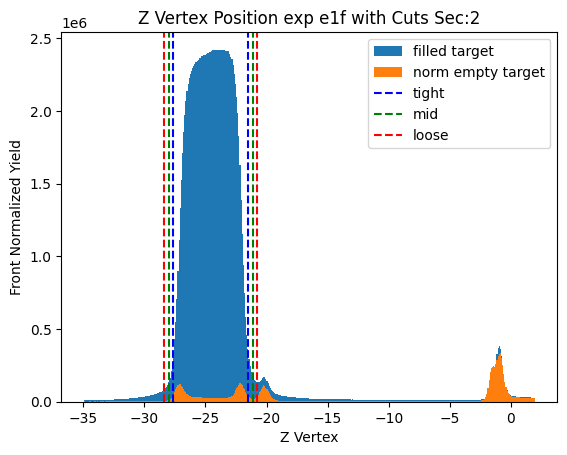

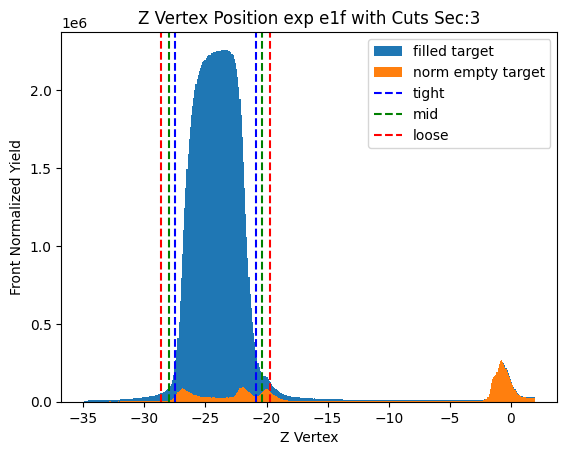

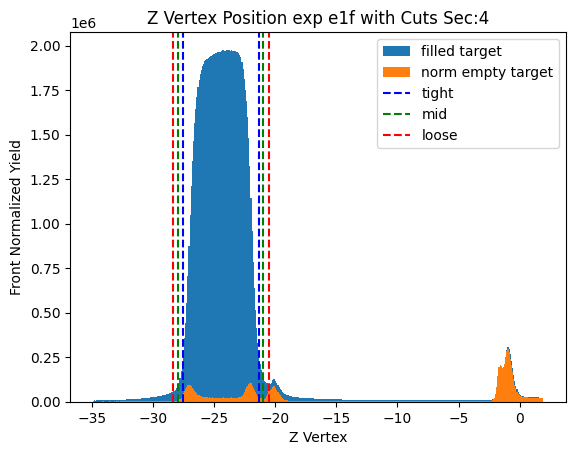

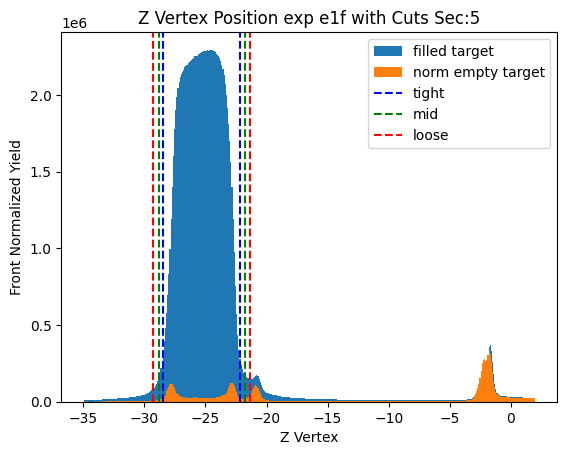

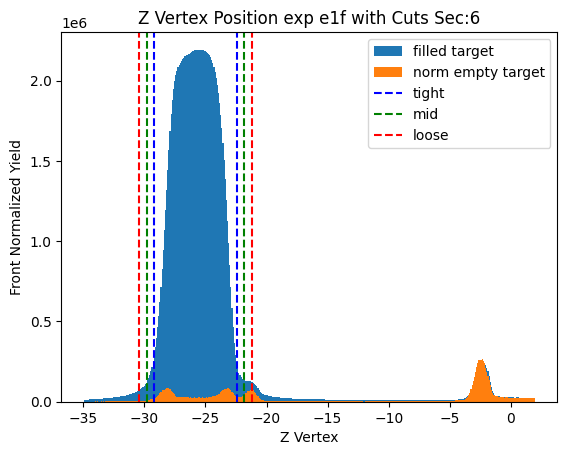

In [19]:
for sec in range(6):
    plt.hist(xvals,weights=yvals_f[sec],label="filled target",bins=len(xvals))
    plt.hist(xvals,weights=yvals_eq[sec],label="norm empty target",bins=len(xvals))
    #plt.scatter(xvals,yvals_eq[sec],label="norm empty target")
    #plt.scatter(xvals,yvals_f,label="filled target")
    for j in range(2):
        for k in range(3):
            if j == 0:
                plt.axvline(x=cut_edges[sec][j][k],color=color_order[k],linestyle="dashed",label=cut_name[k])
            else:
                plt.axvline(x=cut_edges[sec][j][k],color=color_order[k],linestyle="dashed")
    plt.title("Z Vertex Position {} {} with Cuts Sec:{}".format(sim,run,sec+1))
    plt.xlabel("Z Vertex")
    plt.ylabel("Front Normalized Yield")
    plt.legend()
    plt.show()

In [20]:
space = 1.0

int_range = [[cut_edges[sec][0][2]-space,cut_edges[sec][0][2]+space] for sec in range(6)]

def integrate_array(xvals_, yvals_, xmin_, xmax_):
    the_integral = 0.0
    for i in range(len(xvals_)):
        if xvals_[i] >= xmin_ or xvals[i] <= xmax_:
            the_integral += yvals_[i]
    return the_integral



[-25.338572549196677, -24.56838374770644, -24.185618445310368, -24.462008281086632, -25.30876498356277, -25.800140308992226]
[[-27.138572549196677, -23.538572549196676], [-26.368383747706442, -22.76838374770644], [-25.98561844531037, -22.385618445310367], [-26.262008281086633, -22.66200828108663], [-27.10876498356277, -23.50876498356277], [-27.600140308992227, -24.000140308992226]]


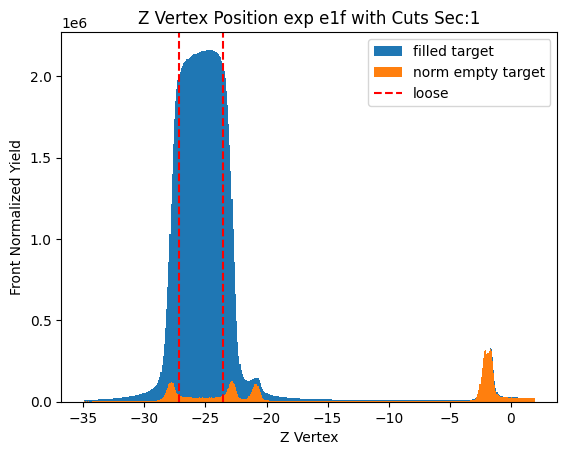

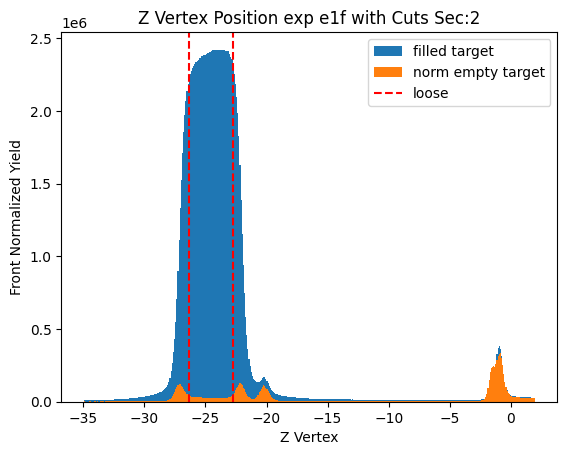

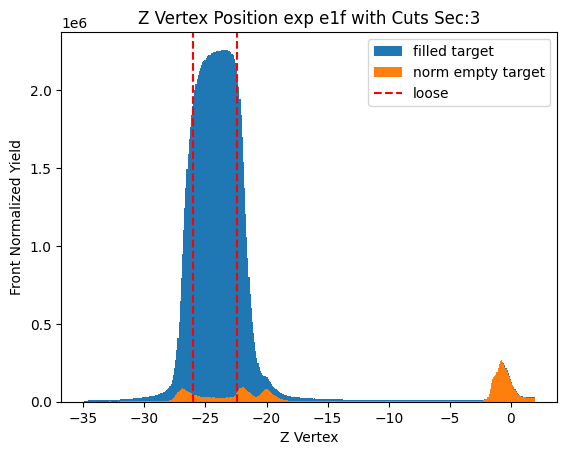

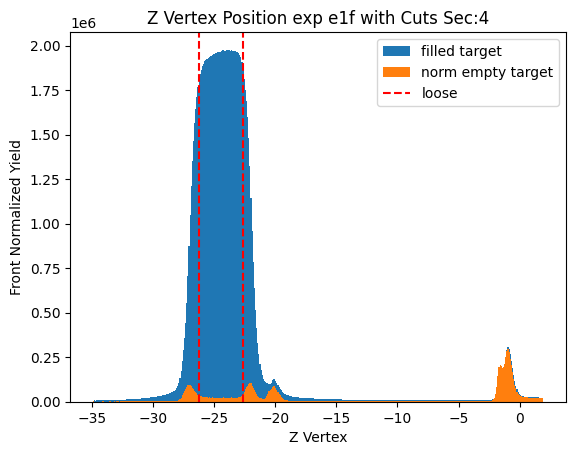

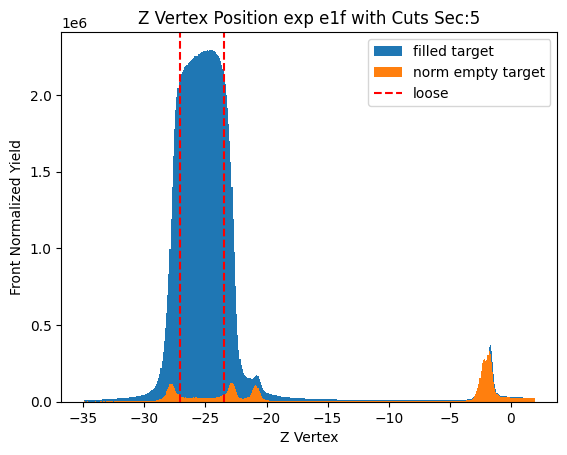

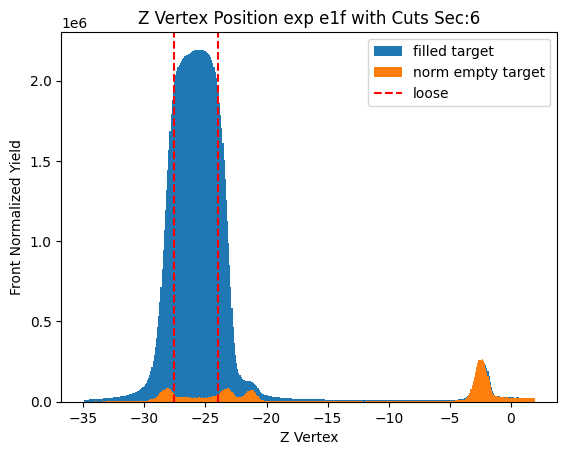

[182.96155475003692, 186.8036367364199, 185.11788989762516, 182.5068530777896, 190.9814852775076, 188.27234151192982]


In [21]:
#Luminosity Correction Factor
x_cen = [(cut_edges[sec][0][2]+cut_edges[sec][1][2])/2 for sec in range(6)]
print(x_cen)
cell_width = 1.8
x_int_bou = [[x_cen[sec]-cell_width,x_cen[sec]+cell_width] for sec in range(6)]
print(x_int_bou)

for sec in range(6):
    plt.hist(xvals,weights=yvals_f[sec],label="filled target",bins=len(xvals))
    plt.hist(xvals,weights=yvals_eq[sec],label="norm empty target",bins=len(xvals))
    #plt.scatter(xvals,yvals_eq[sec],label="norm empty target")
    #plt.scatter(xvals,yvals_f,label="filled target")
    for j in range(2):
        if j == 0:
            plt.axvline(x=x_int_bou[sec][j],color=color_order[k],linestyle="dashed",label=cut_name[k])
        else:
            plt.axvline(x=x_int_bou[sec][j],color=color_order[k],linestyle="dashed")
    plt.title("Z Vertex Position {} {} with Cuts Sec:{}".format(sim,run,sec+1))
    plt.xlabel("Z Vertex")
    plt.ylabel("Front Normalized Yield")
    plt.legend()
    plt.show()
    
L_corr = [integrate_array(xvals,yvals_f[sec],x_int_bou[sec][0],x_int_bou[sec][1])/integrate_array(xvals,yvals_e[sec],x_int_bou[sec][0],x_int_bou[sec][1]) for sec in range(6)]
print(L_corr)


In [23]:
# sim_exp_norm = [integrate_array(xvals,yvals_f[sec],int_range[sec][0],int_range[sec][1])/integrate_array(xvals,yvals_s[sec],int_range[sec][0],int_range[sec][1]) for sec in range(6)]

# yvals_sq = [[yvals_s[sec][i] * sim_exp_norm[sec] for i in range(len(yvals_s[sec]))] for sec in range(6)]
# yerr_sq = [[yerr_s[sec][i] * sim_exp_norm[sec] for i in range(len(yvals_s[sec]))] for sec in range(6)]



NameError: name 'yvals_s' is not defined

In [ ]:
# for sec in range(6):
#     plt.hist(xvals,weights=yvals_f[sec],label="exp",bins=len(xvals))
#     plt.hist(xvals,weights=yvals_sq[sec],label="norm sim",bins=len(xvals),alpha =0.5)
#     #plt.scatter(xvals,yvals_eq[sec],label="norm empty target")
#     #plt.scatter(xvals,yvals_f,label="filled target")
#     for j in range(2):
#         for k in range(3):
#             if j == 0:
#                 plt.axvline(x=cut_edges[sec][j][k],color=color_order[k],linestyle="dashed",label="exp {} cut".format(cut_name[k]))
#             else:
#                 plt.axvline(x=cut_edges[sec][j][k],color=color_order[k],linestyle="dashed")
#     plt.title("Z Vertex Position {} {} Sec:{}".format(sim,run,sec+1))
#     plt.xlabel("Z Vertex")
#     plt.ylabel("Integration Normalized Yield")
#     plt.legend()
#     plt.show()

In [ ]:
# ini_pars = [600000,-5.0,5.0,10.0]

# sim_cut_edges = np.zeros((6,2,3))

# sim_fit_pars = np.zeros((6,4))

# for sec in range(6):
#     plt.hist(xvals,weights=yvals_sq[sec],label="norm sim",bins=len(xvals))
#     #plt.scatter(xvals,yvals_sub[sec],label="Subtracted Data")
#     #plt.scatter(xvals,yvals_f,label="filled target")
#     try:
#         pars, pars_cov = op.curve_fit(Super_Gaus,xvals,yvals_sub[sec],p0=ini_pars,maxfev=5000)
#         cont_x = np.linspace(xvals[0],xvals[xbins-1],200)
#         plt.plot(cont_x,Super_Gaus(cont_x,*pars),label="fit",color='orange')
#         for i in range(4):
#             sim_fit_pars[sec][i] = pars[i]
#         for j in range(2):
#             for k in range(3):
#                 sim_cut_edges[sec][j][k] = super_gaus_cut_bound(gaus_fracs[k],j,*pars)
#                 if j == 0:
#                     plt.axvline(x=sim_cut_edges[sec][j][k],color=color_order[k],linestyle="dashed",label=cut_name[k])
#                 else:
#                     plt.axvline(x=sim_cut_edges[sec][j][k],color=color_order[k],linestyle="dashed")
#     except RuntimeError:
#         print("Runtime Error")
#     except ValueError:
#         print("Value Error") 
#     plt.title("Z Vertex Position {} {} Normalized Sim Sec:{}".format(sim,run,sec+1))
#     plt.xlabel("Z Vertex")
#     plt.ylabel("Integration Normalized Yield")
#     plt.legend()
#     plt.show()

In [24]:
fin_cut_pars = np.zeros((2,6,3,2))

for sec in range(6):
    for cut in range(3):
        for side in range(2):
            fin_cut_pars[0][sec][cut][side] = cut_edges[sec][side][cut]
            fin_cut_pars[1][sec][cut][side] = cut_edges[sec][side][cut]
            #fin_cut_pars[1][sec][cut][side] = sim_cut_edges[sec][side][cut]

In [25]:
all_one_line=True

print(run+" Vertex Cut Parameters")
print("[exp/sim][sec][tight,mid,loose][bot,top]")
for stat in range(2):
    for sec in range(6):
        for cut in range(3):
            for side in range(2):
                if side ==0:
                    if cut==0:
                        if sec ==0:
                            if stat == 0:
                                if all_one_line:
                                    print("\t{{{{",fin_cut_pars[stat][sec][cut][side],end=",")
                                else:
                                    print("{\t{\t{\t{",fin_cut_pars[stat][sec][cut][side],end=",")
                            else:
                                if all_one_line:
                                    print("{{{",fin_cut_pars[stat][sec][cut][side],end=",")
                                else:
                                    print("\t{\t{\t{",fin_cut_pars[stat][sec][cut][side],end=",")
                        else:
                            if all_one_line:
                                print("{{",fin_cut_pars[stat][sec][cut][side],end=",")
                            else:
                                print("\t\t{\t{",fin_cut_pars[stat][sec][cut][side],end=",")
                    else:
                        if all_one_line:
                            print("{",fin_cut_pars[stat][sec][cut][side],end=",")
                        else:
                            print("\t\t\t{",fin_cut_pars[stat][sec][cut][side],end=",")
                elif side ==1:
                    if cut ==2:
                        if sec ==5:
                            if stat ==1:
                                print(fin_cut_pars[stat][sec][cut][side],"}}}}")
                            else:
                                if all_one_line:
                                    print(fin_cut_pars[stat][sec][cut][side],end="}}},")
                                else:
                                    print(fin_cut_pars[stat][sec][cut][side],"}}},")
                        else:
                            if all_one_line:
                                print(fin_cut_pars[stat][sec][cut][side],end="}},")
                            else:
                                print(fin_cut_pars[stat][sec][cut][side],"}},")
                    else:
                        if all_one_line:
                            print(fin_cut_pars[stat][sec][cut][side],end="},")
                        else:
                            print(fin_cut_pars[stat][sec][cut][side],"},")
                else:
                    if all_one_line:
                        print(fin_cut_pars[stat][sec][cut][side],end="},")
                    else:
                        print(fin_cut_pars[stat][sec][cut][side],end="},")
                                
                                
                                
                                

e1f Vertex Cut Parameters
[exp/sim][sec][tight,mid,loose][bot,top]
	{{{{ -28.428902621450433,-22.24824247694292},{ -28.793895577015824,-21.88324952137753},{ -29.201997150268518,-21.475147948124835}},{{ -27.63991982312318,-21.496847672289704},{ -27.997126503701754,-21.13964099171113},{ -28.39587481345773,-20.740892681955152}},{{ -27.47724334130478,-20.893993549315955},{ -28.010342053750733,-20.360894836870003},{ -28.62977935160396,-19.741457539016775}},{{ -27.563047785878727,-21.360968776294538},{ -27.950852097830545,-20.97316446434272},{ -28.38715375531312,-20.536862806860146}},{{ -28.441306458140634,-22.176223508984908},{ -28.838190114458335,-21.779339852667206},{ -29.285357745603008,-21.332172221522534}},{{ -29.173918945630625,-22.426361672353828},{ -29.755786802387075,-21.844493815597378},{ -30.43800807268689,-21.16227254529756}}},{{{ -28.428902621450433,-22.24824247694292},{ -28.793895577015824,-21.88324952137753},{ -29.201997150268518,-21.475147948124835}},{{ -27.63991982312318,-2